In [15]:
# !pip install xgboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
# Config plt.
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')
rcParams['figure.figsize'] = 8, 5

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

from plotnine import *

##ML

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_val_score
from sklearn.inspection import partial_dependence

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [7]:
df = pd.read_csv('../data/cleaned_data.csv')

# Flights Price Machine Learning
## Description
Flight tickets price prediction using different machine learning models such as K-nearest neighbor, decision tree & linear model.
## Data
The dataset contains flight tickets price from different airline companies along with other features such as the flight destination, and duration.
| Feature        |  Description                                       |
|   :---:        |     :---:                                          |
| Price(target)  | The price of the ticket.                           |
| Airline        | The airline name.                                  |
| Source         | The source from which the service begins.          |
| Destination    | The destination where the service ends.            |
| Dep_Time       | The time when the journey starts from the source.  |
| Arrival_Time   | The arrival time at the destination.               |
| Duration       | The total flight duration.                         |
| Total_Stops    | The total stops between the source and destination.|
| Additional_Info| Any additional information about the flight.       |
|Date_of_Journey | The date of the journey.                           |
|Route           | The route taken by the flight to reach the destination.|

<br>

| Number of Entries |  Number of Features  |
|   :---:           |     :---:            |
|   10683           |           11         |


### Data Cleaning

- Extracted Year, Month, Day form "Date_of_Juourney"
- Dropped "year" since its value is the same for all entires
- Dropped "date_of_journey"
- Converted "Duration" to seconds
- Modified "additional_info" value "No Info" to "No info"
- Dropped messing values
- Dropped duplicated entries (kept one)
- Converted "total_stops" from string to numeric
- Categorize "dep_time"and "arrival_time" (i.e. "mid_night", "moring", "afternoon", "evening")
- Dropped "route" since we will be using "total_stops"

In [13]:
# Modify feature names to be lower cased.
df.columns = df.columns.str.lower()

# Change "data_of_journey" type to datetime.
df.date_of_journey = pd.to_datetime(df.date_of_journey, infer_datetime_format=True)

# Create "year", "month", and "day" features.
df['year'] = pd.DatetimeIndex(df.date_of_journey).year
df['month'] = pd.DatetimeIndex(df.date_of_journey).month
df['day'] = pd.DatetimeIndex(df.date_of_journey).day

# Convert "duration to seconds"
df.duration = df.duration.apply(lambda x: f'{x} 0m' if not 'm' in x else x)
df.duration = df.duration.apply(lambda x: f'0h {x}' if not 'h' in x else x)
df.duration = df.duration.apply(lambda x: int(x.split()[0][:-1])*3600 + int(x.split()[1][:-1])*60)

# Drop "year" since its value is the same for all entires.
df.drop(columns=['year'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Modify "additional_info" value "No Infor" to "No info"
df.additional_info = df.additional_info.str.replace('No Info', 'No info')

# Drop Null values.
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop douplicated entires.
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Modify "total_stops" values to contain only the number.
df.total_stops = df.total_stops.apply(lambda x: int(x.split()[0]) if not 'non-stop' in x.split()[0] else 0)

# Categorize "dep_time"and "arrival_time".
def categorizee_time(input):
    time = input.split()[0]
    if int(time[:2]) >= 0 and int(time[:2]) < 6:
        return 'mid_night'
    elif int(time[:2]) >= 6 and int(time[:2]) < 12:
        return 'morning'
    elif int(time[:2]) >= 12 and int(time[:2]) < 18:
        return 'afternoon'
    elif int(time[:2]) >= 18 and int(time[:2]) < 24:
        return 'evening'

df.dep_time = df.dep_time.apply(categorizee_time)
df.arrival_time = df.arrival_time.apply(categorizee_time)

# Drop "date_of_journey" and "route".
df.drop(columns=['date_of_journey', 'route'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'date_of_journey'

In [19]:
# Show a smaple of the cleaned dataset.
df.sample(2)

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,month,day
3983,Multiple carriers,Delhi,Cochin,morning,evening,35100,1,No info,11622,6,24
8359,Multiple carriers,Delhi,Cochin,mid_night,afternoon,31500,1,No info,10197,5,15


### EDA

In [14]:
# Display stats summary of numeric values.
df.describe()

,duration,total_stops,price,month,day
count,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000
mean,37786.895431,0.802332,9026.790289,4.701491,13.463200
std,30041.942724,0.660609,4624.849541,1.163802,8.467493
min,300.000000,0.000000,1759.000000,3.000000,1.000000
25%,10200.000000,0.000000,5224.000000,3.000000,6.000000
50%,30300.000000,1.000000,8266.000000,5.000000,12.000000
75%,54600.000000,1.000000,12344.750000,6.000000,21.000000
max,171600.000000,4.000000,79512.000000,6.000000,27.000000


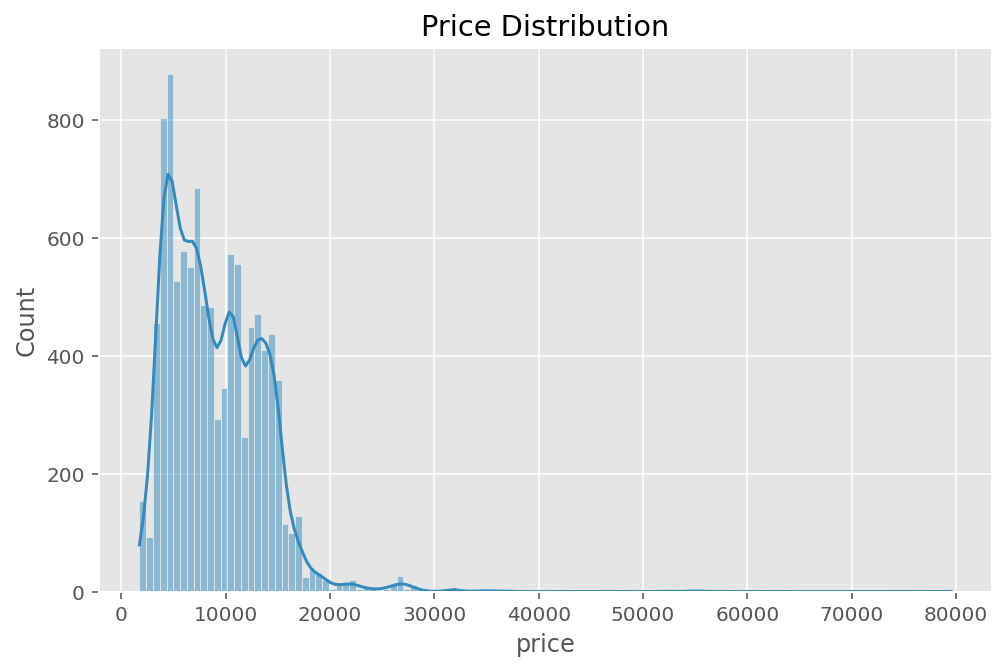

In [15]:

# Plot a box plot of "price".
sns.histplot(df.price, kde=True)
plt.title('Price Distribution');
#insight: price distribution is positively-skewed.

Insight: Price distribution is positively-skewed.

In [22]:
# Display the correlation between the different features.
df.corr().style.background_gradient()


,duration,total_stops,price,month,day
duration,1.000000,0.727982,0.501758,0.004874,-0.029810
total_stops,0.727982,1.000000,0.602013,0.039003,-0.018937
price,0.501758,0.602013,1.000000,-0.113396,-0.159044
month,0.004874,0.039003,-0.113396,1.000000,-0.038331
day,-0.029810,-0.018937,-0.159044,-0.038331,1.000000


Insight: Price is highly correlated with total stops and moderately correlated with duration.

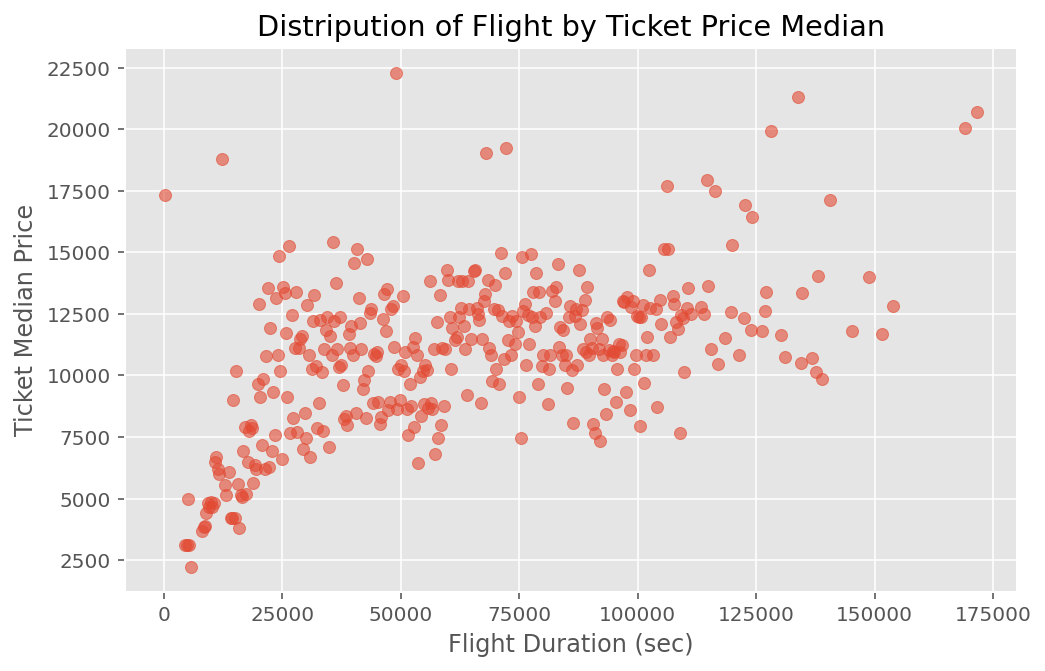

In [23]:
# Group by duration, and used median of price
# Note: median was chosen because price distribution is positively-skewed.
avg_price_per_duration = df.groupby(['duration'], as_index=False).median()

#Plot a scatter plot of "price" with respect to "duration".
plt.scatter(x=avg_price_per_duration.duration, y=avg_price_per_duration.price, alpha=0.6)
plt.xlabel('Flight Duration (sec)')
plt.ylabel('Ticket Median Price')
plt.title('Distripution of Flight by Ticket Price Median');

Insight: As the durations increase, the median price increases.

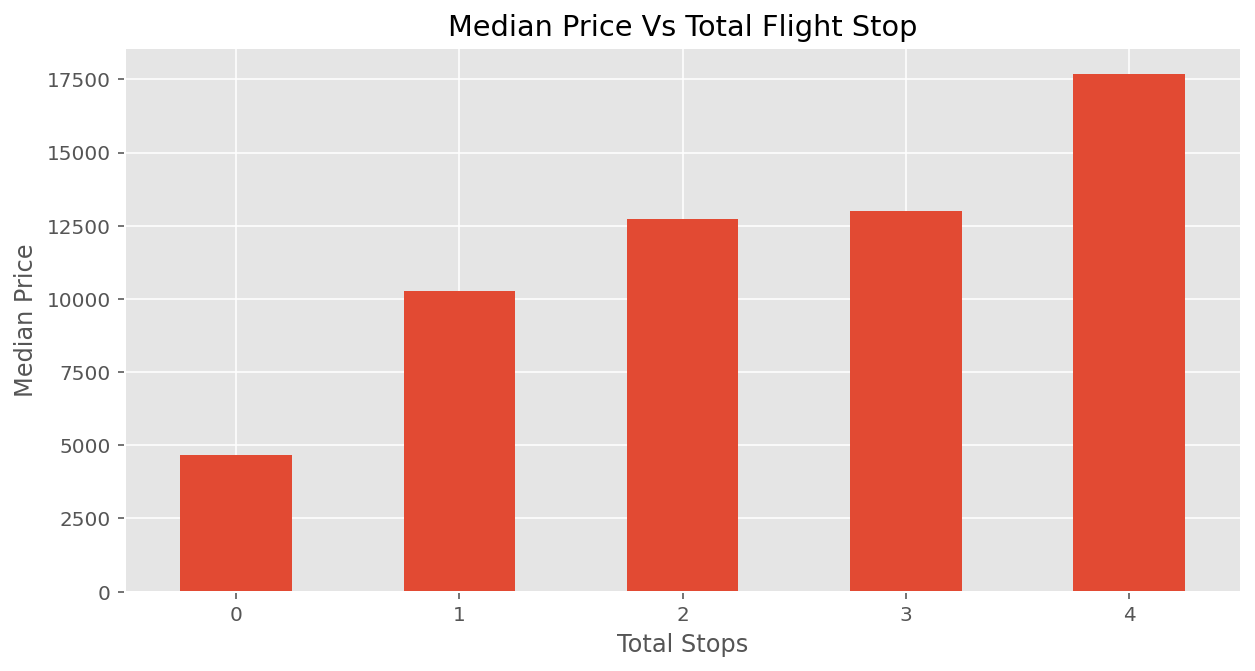

In [24]:
fig = plt.figure(figsize=(10,5))
median_stops_price = df.groupby('total_stops')['price'].median()
median_stops_price.plot.bar(x = 'total_stops', rot=360)
#df.sort_values('airline',inplace=True) << I WANT TO ARRANGE IT IN DESCENDING
plt.title("Median Price Vs Total Flight Stop")
plt.xlabel("Total Stops")
plt.ylabel("Median Price");

Insight: Median price increase as the total stops increase.

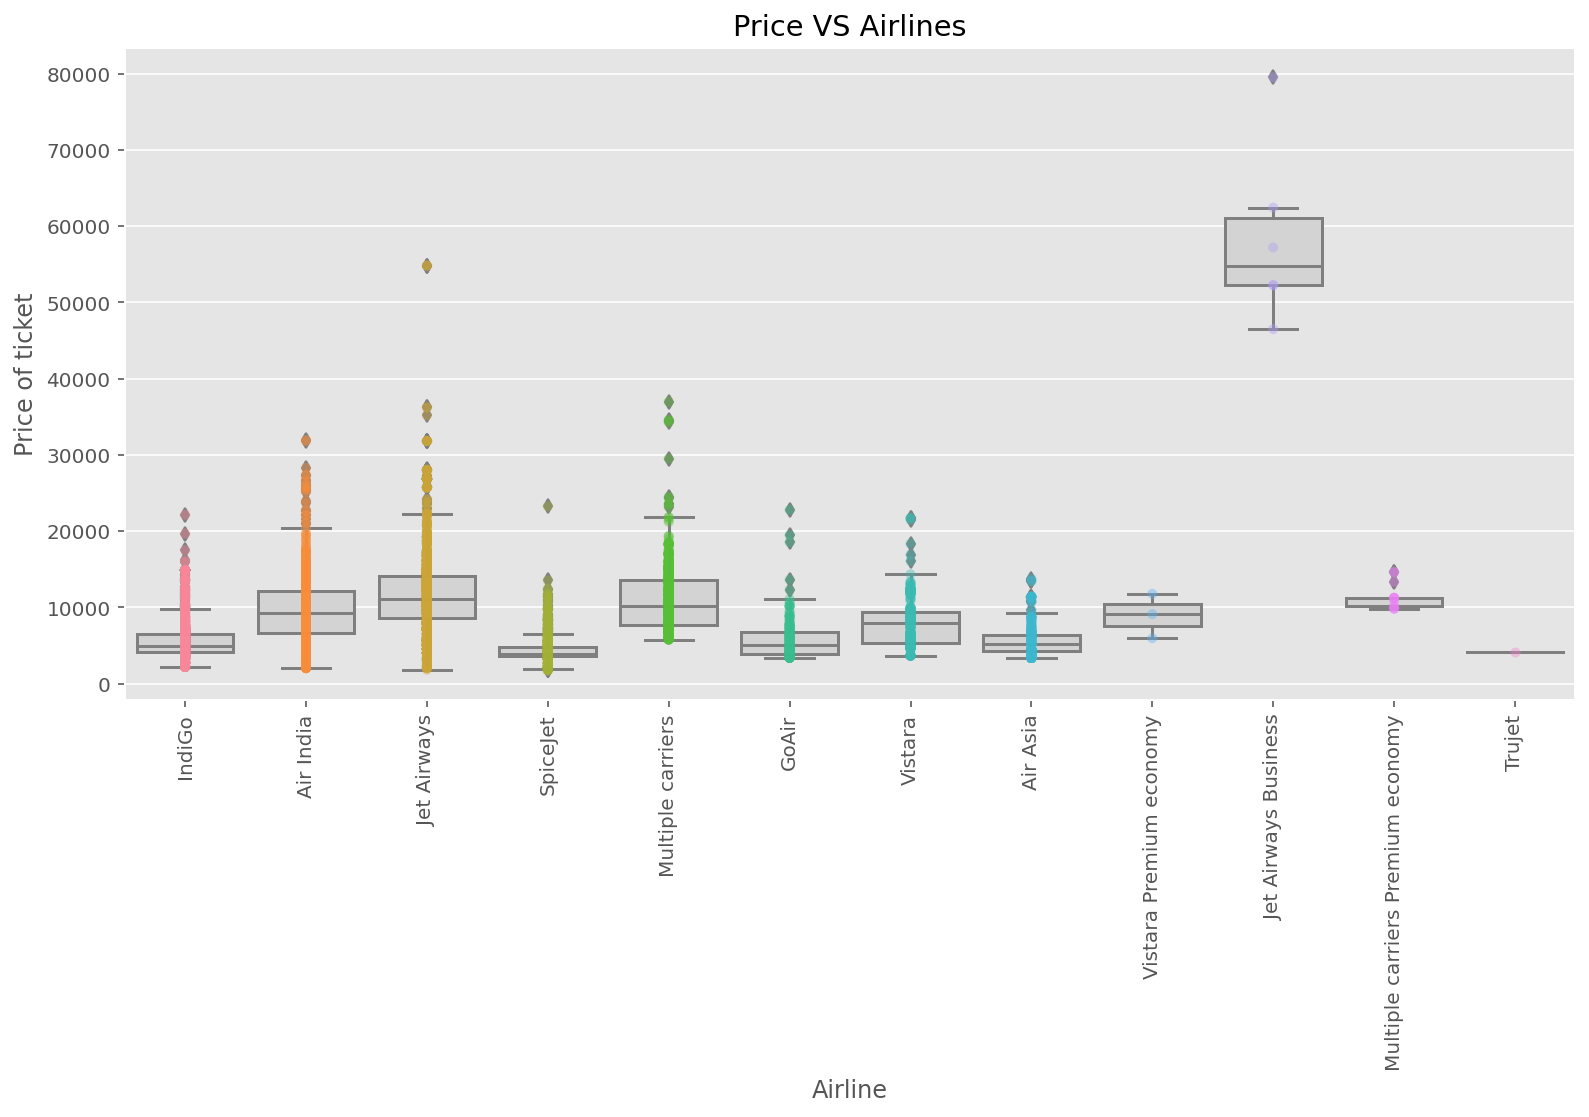

In [25]:

#Comparing prices for each airline
plt.figure(figsize = (13,6))
sns.stripplot(data=df, x='airline', y='price', jitter=False, alpha=0.4)
sns.boxplot(df.airline, df.price, color='lightgray')
plt.title('Price VS Airlines')
plt.xticks
plt.xlabel('Airline')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90);

Insight: Jet Airways Business has the heighest median price.

### Machine Learning

#### Linear Regression

#### KNN
Model Steps:
- Create train/test split
- Separate features from labels and only use numeric features
- Features engineering  
- Create grid of hyperparameter values
- 10 fold CV object
- Defind a loss function (RMSE)
- KNN model object
- Tune the model using grid search

In [3]:
# Split the data into train and test splits.
train, test = train_test_split(df, train_size=0.8, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop('price', axis=1)
y_train = train['price']
X_test = test.drop('price', axis=1)
y_test = test['price']

In [16]:

# # Split the data into train and test splits.
# train, test = train_test_split(df, train_size=0.8, random_state=123)

# # separate features from labels and only use numeric features
# X_train = train.drop('price', axis=1)
# y_train = train['price']
# X_test = test.drop('price', axis=1)
# y_test = test['price']
# create KNN model object
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10)#, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'knn__n_neighbors': range(2, 26)}

# Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()

# One-hot encode remaining categorical features.
encoder = OneHotEncoder(handle_unknown="ignore")

# combine all steps into a preprocessing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("std_encode", scaler, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object"))
  ])

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("knn", knn),
])

# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's k value
print('Optimal hyperparameter')
print(f'Best K value: {results.best_estimator_.get_params().get("knn__n_neighbors")}')

# Best model's cross validated RMSE
print(f'Best KNN RMSE: {abs(results.best_score_)}', end='\n\n')


Optimal hyperparameter
Best K value: 3
Best KNN RMSE: 2142.801354153572



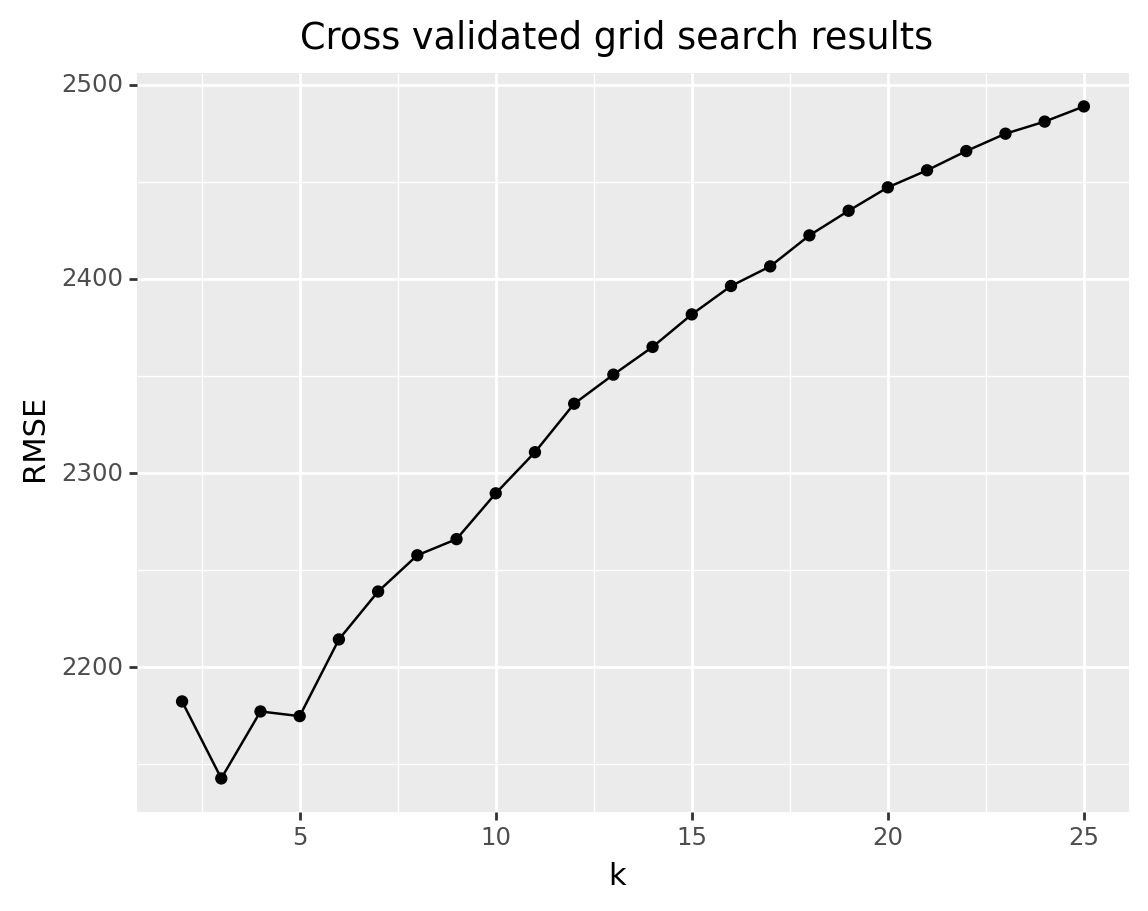

<ggplot: (137648891034)>

In [27]:
# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

#### Decision Tree
Model Steps:
- Create train/test split
- Separate features from labels and only use numeric features
- Features engineering  
- Create grid of hyperparameter values
- 10 fold CV object
- Defind a loss function (RMSE)
- Decision tree model object
- Tune the model using grid search

In [28]:
# create train/test split
train, test = train_test_split(df, train_size=0.8, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("price", axis=1)
y_train = train[["price"]]

#Decision Tress model object
dt_mod = DecisionTreeRegressor()

#loss function
loss = 'neg_root_mean_squared_error'

# 10 fold CV object
kfold = KFold(n_splits=10) #random_state=123, shuffle=True)

# create new feature set with encoded features
X_train_encoded = pd.get_dummies(X_train)

# Create grid of hyperparameter values
hyper_grid = {
  'ccp_alpha': [1e-1, 1e-5, 1e-10],
  'max_depth': [1, 8, 15],
  'min_samples_split': [2, 21, 40]
  }

#Tune the model using grid search
grid_search = GridSearchCV(dt_mod, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)


# Optimal penalty parameter in grid search
print('Optimal hyperparameter')
print("ccp_alpha: ", results.best_estimator_.get_params().get('ccp_alpha'))
print("max_depth: ", results.best_estimator_.get_params().get('max_depth'))
print("min_samples_split: ", results.best_estimator_.get_params().get('min_samples_split'), end="\n\n")

# Best model's cross validated RMSE
print("Best Decision Tree cross validated RMSE: ", round(abs(results.best_score_), 2))

Optimal hyperparameter
ccp_alpha:  0.1
max_depth:  15
min_samples_split:  21

Best Decision Tree cross validated RMSE:  1845.25


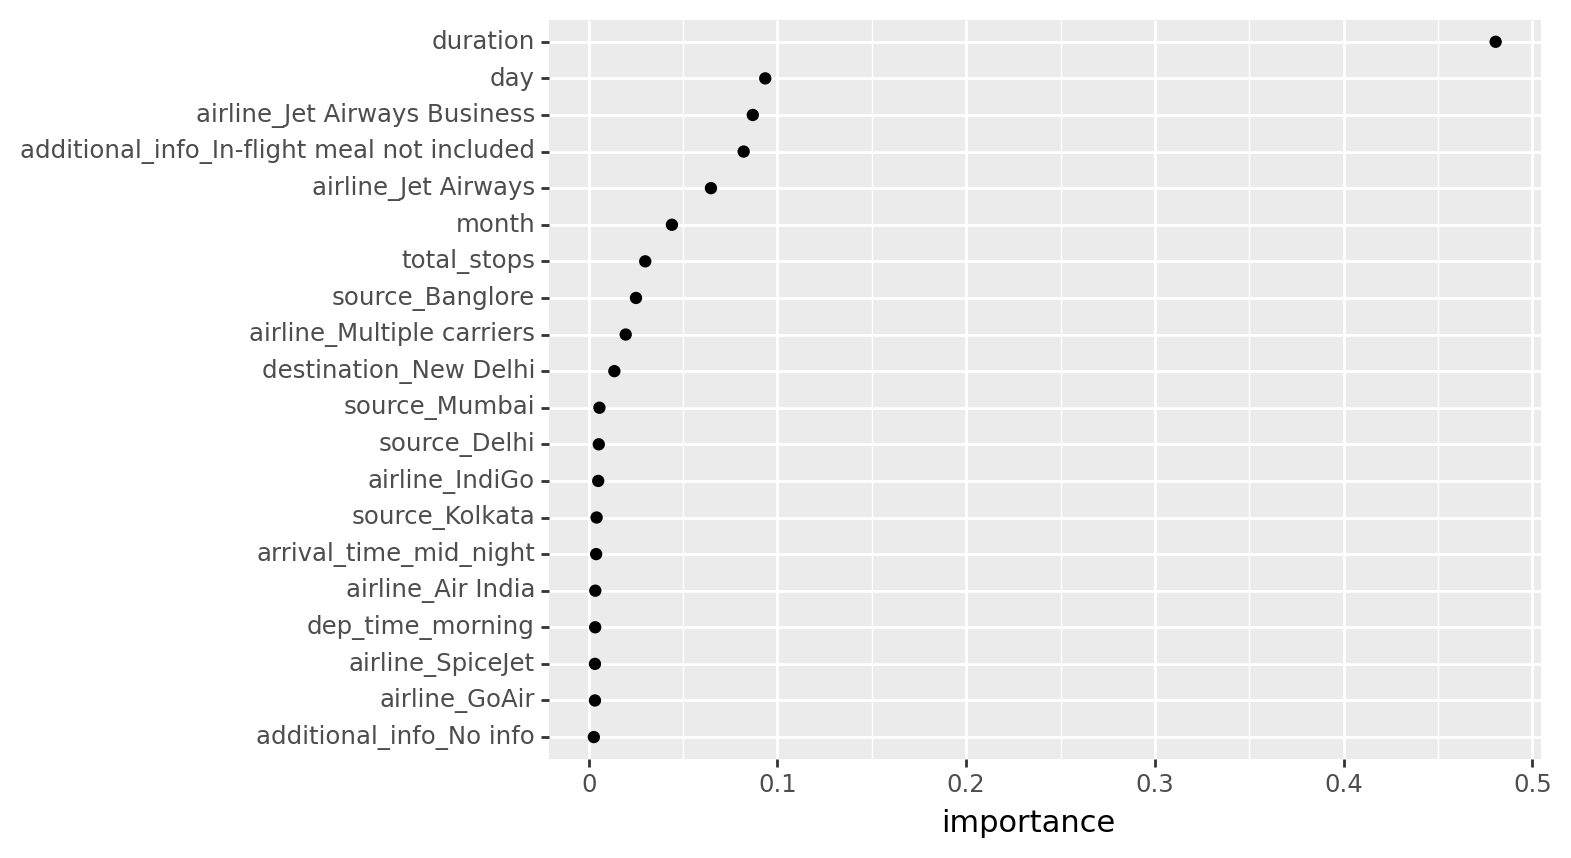

<ggplot: (137648551458)>

In [29]:
# create final model object
best_mod = results.best_estimator_
best_mod_fit = best_mod.fit(X_train_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': X_train_encoded.columns,
                   'importance': best_mod_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

Duration has is the important feature

#### Gradient Boosting

In [4]:
# One hot encode remaining nominal features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Combine into a pre-processing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
   ("one-hot", encoder, selector(dtype_include="object")),
   ]
  )

In [8]:
# GBM Estimator Model Object
xgb_mod = xgb.XGBRegressor()

#Loss Function
loss = 'neg_root_mean_squared_error'

#Creating a pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])


kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Setting the Hyperparameters
hyper_grid = {
  'xgb_mod__n_estimators': [1000, 2500, 5000],
  'xgb_mod__learning_rate': [0.001, 0.01, 0.1],
  'xgb_mod__max_depth': [3, 5, 7, 9],
  'xgb_mod__min_child_weight': [1, 5, 15] 
}

# Implementing a five fold CV
results = cross_val_score(model_pipeline, X_train, y_train, cv=kfold, scoring=loss)

print('Gradient Boosting RMSE: ', np.abs(np.mean(results)), end='\n\n')


# create random search object
random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

# Execute random search
random_search_results = random_search.fit(X_train, y_train)

# Best model score
print('Gradient Boosting random search RMSE: ', np.abs(random_search_results.best_score_), end='\n\n')

# Optimal penalty parameter in grid search
print('Optimal hyperparameter')
print("xgb_mod__n_estimators: ", random_search_results.best_estimator_.get_params().get('xgb_mod__n_estimators'))
print("xgb_mod__learning_rate: ", random_search_results.best_estimator_.get_params().get('xgb_mod__learning_rate'))
print("xgb_mod__max_depth: ", random_search_results.best_estimator_.get_params().get('xgb_mod__max_depth'))
print("xgb_mod__min_child_weight: ", random_search_results.best_estimator_.get_params().get('xgb_mod__min_child_weight'), end="\n\n")

Gradient Boosting RMSE:  1669.3974306455425

Gradient Boosting random search RMSE:  1614.05097475437

Optimal hyperparameter
xgb_mod__n_estimators:  2500
xgb_mod__learning_rate:  0.01
xgb_mod__max_depth:  9
xgb_mod__min_child_weight:  1



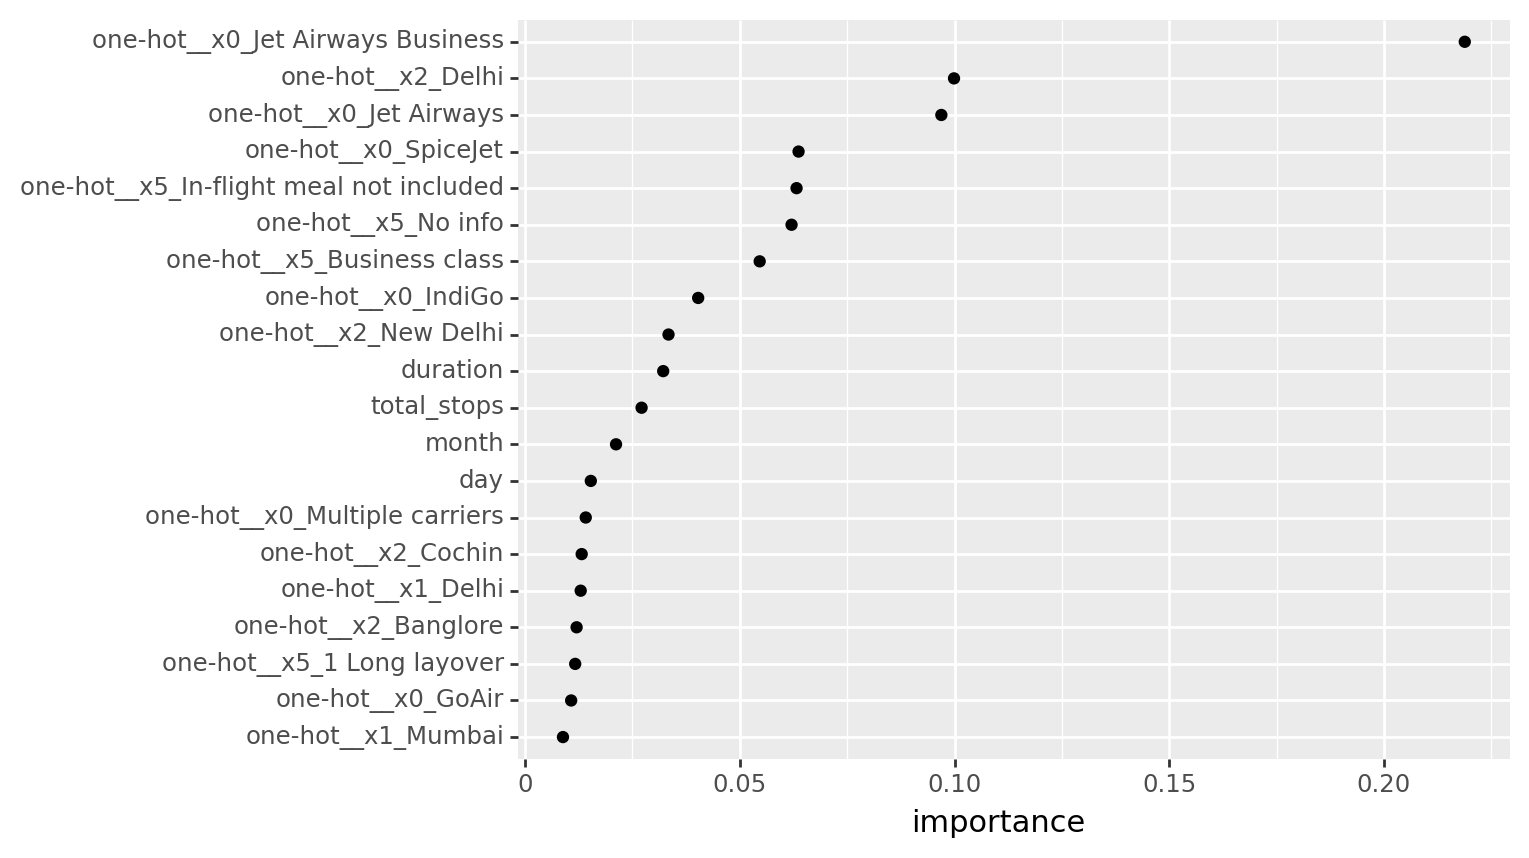

<ggplot: (8736197247696)>

In [9]:
#This is to separate the features or attribute from the target
X_train = train.drop("price", axis=1)
y_train = train[["price"]]

# preprocess training data
X_encoded = preprocessor.fit_transform(X_train)

# create final model object
final_model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75
)

final_model_fit = final_model.fit(X_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': final_model_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

#### Deep Learning